<a href="https://colab.research.google.com/github/lbeland/SIGE_Practica2/blob/main/SIGE_practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np # For attribute processing later

# --- User-defined paths ---

# Path to the main CUB_200_2011 dataset directory (containing images.txt, classes.txt etc.)
dataset_metadata_path = '/content/drive/MyDrive/SIGE_Praktika2/data additional/'

# Path to your x20 image folder (containing the 20 class subfolders with images)
path_to_x20_image_files = '/content/drive/MyDrive/SIGE_Praktika2/data x20/'

# --- Check paths ---
if not os.path.isdir(dataset_metadata_path):
    print(f"ERROR: Metadata path {dataset_metadata_path} not found.")
if not os.path.isdir(path_to_x20_image_files):
    print(f"ERROR: x20 image folder {path_to_x20_image_files} not found.")

# --- Paths to specific metadata files ---
images_txt_path = os.path.join(dataset_metadata_path, 'images.txt')
image_class_labels_txt_path = os.path.join(dataset_metadata_path, 'image_class_labels.txt')
classes_txt_path = os.path.join(dataset_metadata_path, 'classes.txt')
attributes_txt_path = os.path.join(dataset_metadata_path, 'attributes.txt')
image_attribute_labels_txt_path = os.path.join(dataset_metadata_path, 'image_attribute_labels.txt')

In [7]:
# Load images.txt: <image_id> <filepath_within_images_folder>
images_df = pd.read_csv(images_txt_path, sep=' ', names=['image_id', 'original_relative_filepath'])
print(f"Loaded images.txt: {len(images_df)} entries")

# Load image_class_labels.txt: <image_id> <class_id>
image_class_labels_df = pd.read_csv(image_class_labels_txt_path, sep=' ', names=['image_id', 'class_id'])
print(f"Loaded image_class_labels.txt: {len(image_class_labels_df)} entries")

# Load classes.txt: <class_id> <class_name>
classes_df = pd.read_csv(classes_txt_path, sep=' ', names=['class_id', 'class_name'])
print(f"Loaded classes.txt: {len(classes_df)} entries (Total CUB classes)")

# Merge them to get a master list of all images with their class info
master_df = pd.merge(images_df, image_class_labels_df, on='image_id')
master_df = pd.merge(master_df, classes_df, on='class_id')

print("\nMaster DataFrame with all CUB image metadata (sample):")
print(master_df.head())

Loaded images.txt: 11788 entries
Loaded image_class_labels.txt: 11788 entries
Loaded classes.txt: 200 entries (Total CUB classes)

Master DataFrame with all CUB image metadata (sample):
   image_id                         original_relative_filepath  class_id  \
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...         1   

                   class_name  
0  001.Black_footed_Albatross  
1  001.Black_footed_Albatross  
2  001.Black_footed_Albatross  
3  001.Black_footed_Albatross  
4  001.Black_footed_Albatross  


In [8]:
x20_class_names_from_folders = []
if os.path.isdir(path_to_x20_image_files):
    potential_class_folders = sorted(os.listdir(path_to_x20_image_files))
    for class_folder_name in potential_class_folders:
        if os.path.isdir(os.path.join(path_to_x20_image_files, class_folder_name)):
            x20_class_names_from_folders.append(class_folder_name)
    print(f"\nFound {len(x20_class_names_from_folders)} class folders in '{path_to_x20_image_files}'.")
    print("First 5 class names from x20 folders:", x20_class_names_from_folders[:5])
else:
    print(f"ERROR: x20 image folder '{path_to_x20_image_files}' not found or not a directory.")

# Filter the master_df for these 20 classes
df_selected_20_classes = master_df[master_df['class_name'].isin(x20_class_names_from_folders)].copy()
print(f"Number of images in master_df belonging to these {len(x20_class_names_from_folders)} classes: {len(df_selected_20_classes)}")


Found 20 class folders in '/content/drive/MyDrive/SIGE_Praktika2/data x20/'.
First 5 class names from x20 folders: ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet']
Number of images in master_df belonging to these 20 classes: 1115


In [10]:
# Construct the full path to images based on your x20_image_files directory
# The 'original_relative_filepath' often includes the class name as a folder.
# e.g. if path_to_x20_image_files is '/content/.../x20/'
# and original_relative_filepath is '001.Black_footed_Albatross/image.jpg'
# the full path becomes '/content/.../x20/001.Black_footed_Albatross/image.jpg'

df_selected_20_classes['full_actual_path'] = df_selected_20_classes['original_relative_filepath'].apply(
    lambda rel_path: os.path.join(path_to_x20_image_files, rel_path)
)

# Keep only rows where the image file actually exists in your x20 folder
existing_image_mask = df_selected_20_classes['full_actual_path'].apply(os.path.exists)
x20_final_df = df_selected_20_classes[existing_image_mask].copy()

print(f"\nNumber of images found physically present in x20 folder: {len(x20_final_df)}")
if len(x20_final_df) == 0 and len(df_selected_20_classes) > 0:
    print("ERROR: No images found at the constructed paths. Example of a path that was checked:")
    if not df_selected_20_classes.empty:
        print(df_selected_20_classes['full_actual_path'].iloc[0])
    print("Please check: ")
    print("1. `path_to_x20_image_files` is correct.")
    print("2. The subfolder structure inside `path_to_x20_image_files` matches the paths in `images.txt` (e.g., `x20_folder/001.Class_Name/image.jpg`).")
    print("   If your x20 folder does NOT have the class name subdirectories but just images, the path construction needs adjustment.")

print("\nFinal x20 DataFrame (sample):")
print(x20_final_df[['image_id', 'full_actual_path', 'class_id', 'class_name']].head())


Number of images found physically present in x20 folder: 1115

Final x20 DataFrame (sample):
   image_id                                   full_actual_path  class_id  \
0         1  /content/drive/MyDrive/SIGE_Praktika2/data x20...         1   
1         2  /content/drive/MyDrive/SIGE_Praktika2/data x20...         1   
2         3  /content/drive/MyDrive/SIGE_Praktika2/data x20...         1   
3         4  /content/drive/MyDrive/SIGE_Praktika2/data x20...         1   
4         5  /content/drive/MyDrive/SIGE_Praktika2/data x20...         1   

                   class_name  
0  001.Black_footed_Albatross  
1  001.Black_footed_Albatross  
2  001.Black_footed_Albatross  
3  001.Black_footed_Albatross  
4  001.Black_footed_Albatross  


In [11]:
if not x20_final_df.empty:
    # Get unique class names from our final x20 DataFrame
    unique_class_names_in_x20 = sorted(x20_final_df['class_name'].unique())

    # Create mapping for these unique classes
    class_to_int_map_x20 = {name: i for i, name in enumerate(unique_class_names_in_x20)}

    x20_final_df['label_int'] = x20_final_df['class_name'].map(class_to_int_map_x20)

    print("\nFinal x20 DataFrame with 0-indexed 'label_int' (sample):")
    print(x20_final_df[['full_actual_path', 'class_name', 'label_int']].head())
    print(f"\nNumber of unique classes being used: {x20_final_df['label_int'].nunique()}")
    print(f"Min label_int: {x20_final_df['label_int'].min()}, Max label_int: {x20_final_df['label_int'].max()}")
else:
    print("\nSkipping adding 0-indexed labels as x20_final_df is empty.")


Final x20 DataFrame with 0-indexed 'label_int' (sample):
                                    full_actual_path  \
0  /content/drive/MyDrive/SIGE_Praktika2/data x20...   
1  /content/drive/MyDrive/SIGE_Praktika2/data x20...   
2  /content/drive/MyDrive/SIGE_Praktika2/data x20...   
3  /content/drive/MyDrive/SIGE_Praktika2/data x20...   
4  /content/drive/MyDrive/SIGE_Praktika2/data x20...   

                   class_name  label_int  
0  001.Black_footed_Albatross          0  
1  001.Black_footed_Albatross          0  
2  001.Black_footed_Albatross          0  
3  001.Black_footed_Albatross          0  
4  001.Black_footed_Albatross          0  

Number of unique classes being used: 20
Min label_int: 0, Max label_int: 19


In [12]:
if not x20_final_df.empty:
    train_val_df, test_df = train_test_split(
        x20_final_df,
        test_size=0.2,
        random_state=42,
        stratify=x20_final_df['label_int'] # Stratify by the new 0-indexed label
    )
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=0.25,
        random_state=42,
        stratify=train_val_df['label_int'] # Stratify by the new 0-indexed label
    )
    print(f"\nData Splitting for x20 dataset:")
    print(f"Training set size: {len(train_df)} images")
    print(f"Validation set size: {len(val_df)} images")
    print(f"Test set size: {len(test_df)} images")
else:
    print("\nSkipping train/val/test split as x20_final_df is empty.")


Data Splitting for x20 dataset:
Training set size: 669 images
Validation set size: 223 images
Test set size: 223 images


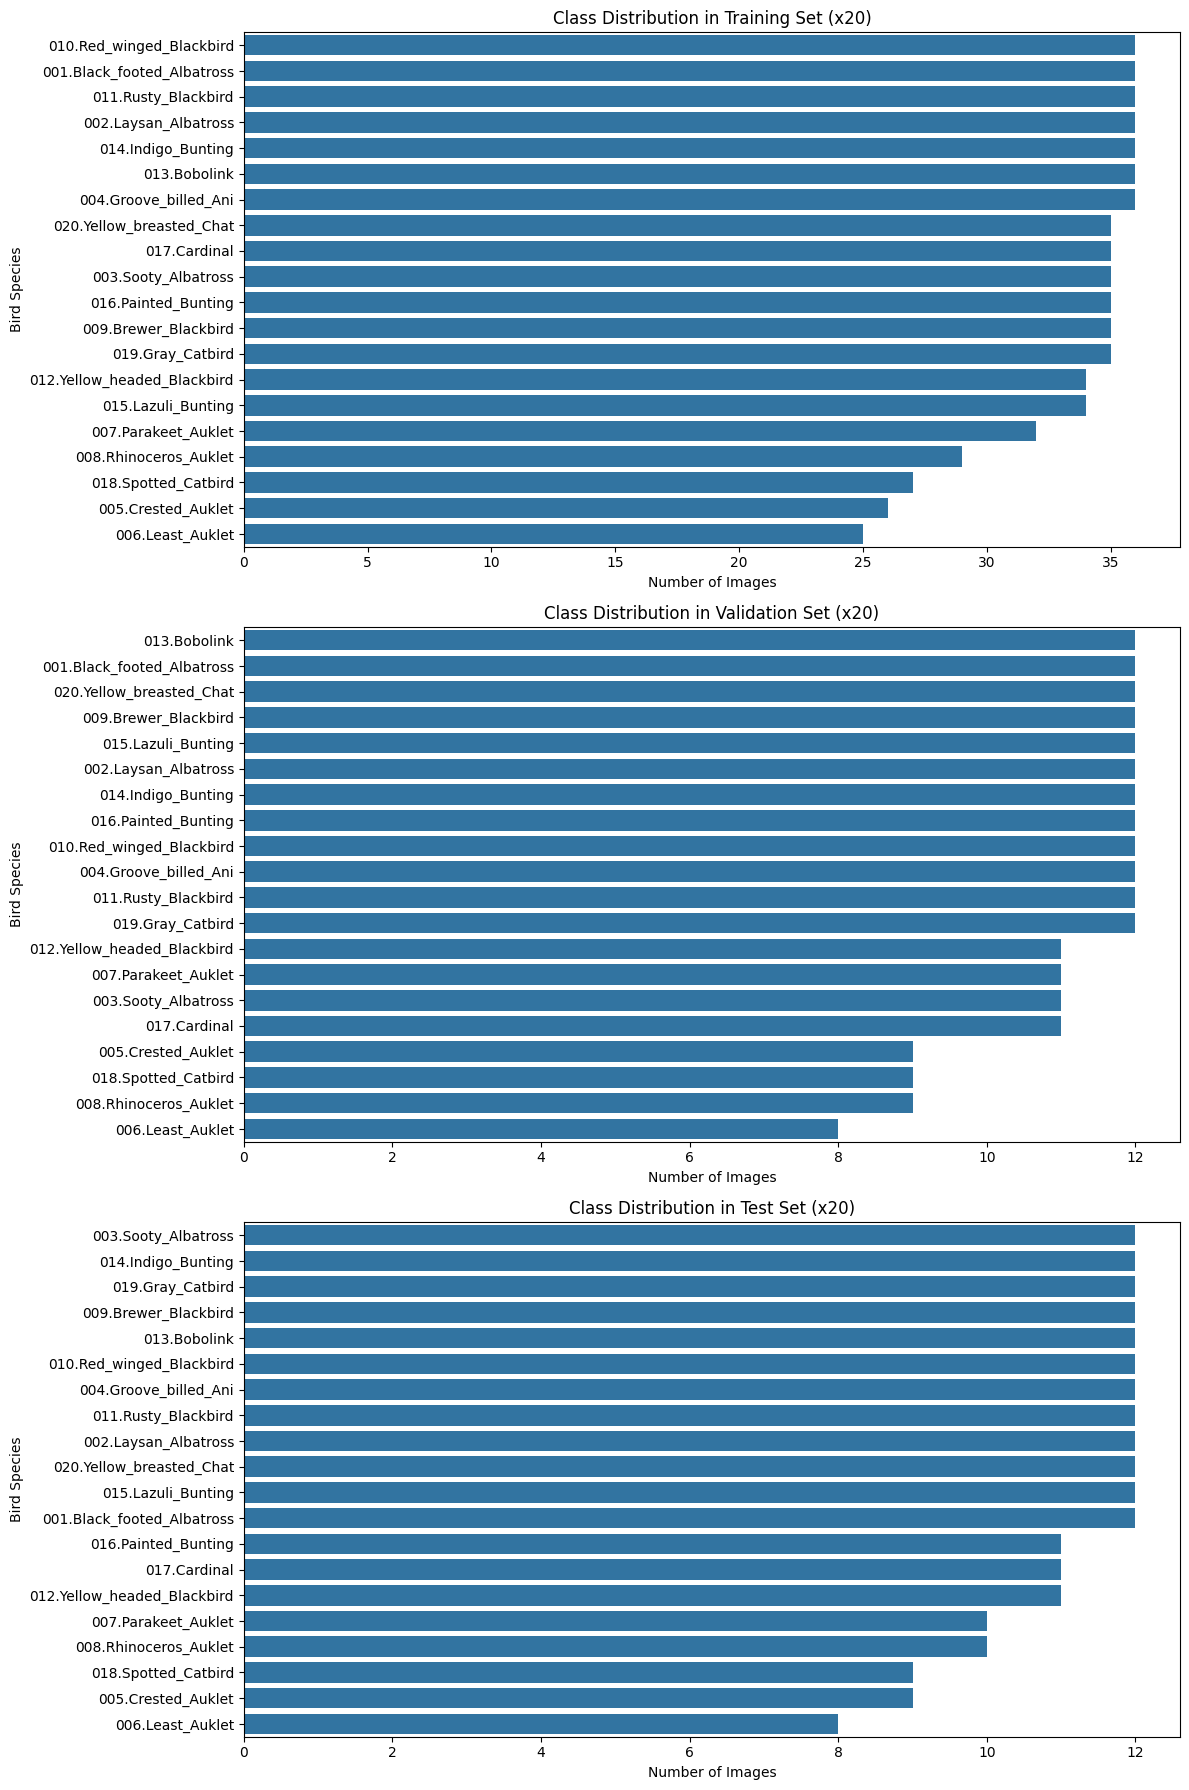

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'train_df' in locals() and not train_df.empty:
    plt.figure(figsize=(12, 18))

    plt.subplot(3, 1, 1)
    sns.countplot(y=train_df['class_name'], order=train_df['class_name'].value_counts().index)
    plt.title('Class Distribution in Training Set (x20)')
    plt.xlabel('Number of Images')
    plt.ylabel('Bird Species')

    if 'val_df' in locals() and not val_df.empty:
        plt.subplot(3, 1, 2)
        sns.countplot(y=val_df['class_name'], order=val_df['class_name'].value_counts().index)
        plt.title('Class Distribution in Validation Set (x20)')
        plt.xlabel('Number of Images')
        plt.ylabel('Bird Species')

    if 'test_df' in locals() and not test_df.empty:
        plt.subplot(3, 1, 3)
        sns.countplot(y=test_df['class_name'], order=test_df['class_name'].value_counts().index)
        plt.title('Class Distribution in Test Set (x20)')
        plt.xlabel('Number of Images')
        plt.ylabel('Bird Species')

    plt.tight_layout()
    plt.show()
else:
    print("DataFrames (train_df, val_df, test_df) not available for class distribution plots.")

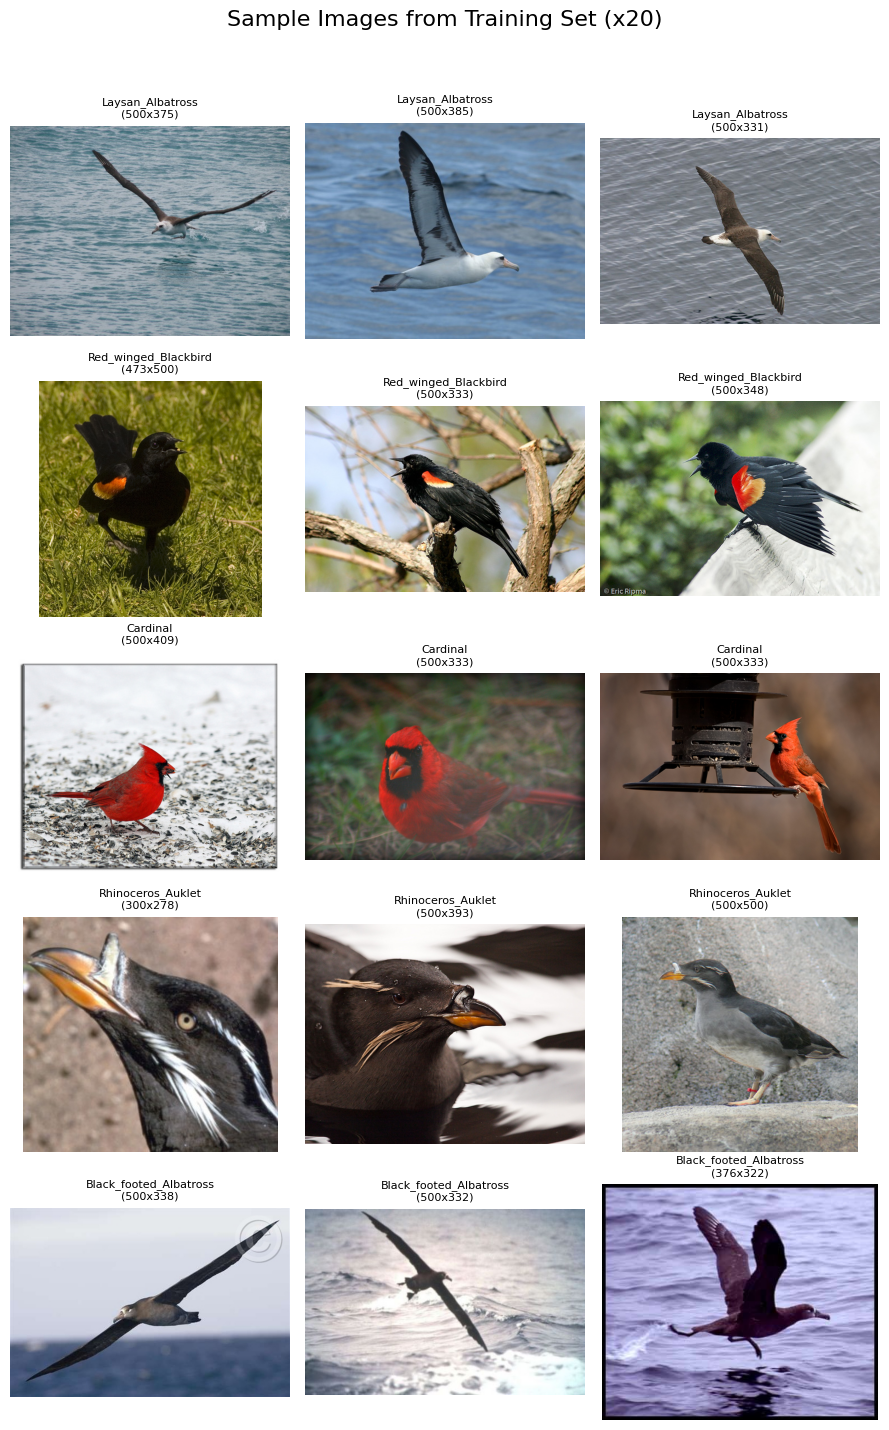

In [18]:
import random
from PIL import Image # Pillow library for image manipulation

if 'train_df' in locals() and not train_df.empty:
    unique_labels_in_train = train_df['class_name'].unique()
    num_classes_to_show = min(len(unique_labels_in_train), 5) # Show up to 5 classes
    num_samples_per_class = 3 # Show 3 samples per class

    plt.figure(figsize=(num_samples_per_class * 3, num_classes_to_show * 3))

    for i, label_name in enumerate(random.sample(list(unique_labels_in_train), num_classes_to_show)):
        class_samples = train_df[train_df['class_name'] == label_name].sample(num_samples_per_class, random_state=42)
        for j, (_, row) in enumerate(class_samples.iterrows()):
            plt.subplot(num_classes_to_show, num_samples_per_class, i * num_samples_per_class + j + 1)
            try:
                img = Image.open(row['full_actual_path'])
                plt.imshow(img)
                plt.title(f"{label_name.split('.')[-1]}\n({img.size[0]}x{img.size[1]})", fontsize=8) # Show only species name part
                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {row['full_actual_path']}: {e}")
                plt.title("Error loading", fontsize=8)
                plt.axis('off')
    plt.suptitle(f"Sample Images from Training Set (x20)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("train_df not available for image visualization.")

In [22]:
if 'x20_final_df' in locals() and not x20_final_df.empty:
    image_dims = []
    image_aspect_ratios = []
    error_files = []

    for img_path in x20_final_df['full_actual_path']:
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                image_dims.append({'width': width, 'height': height})
                if height > 0: # Avoid division by zero
                    image_aspect_ratios.append(width / height)
        except Exception as e:
            error_files.append(img_path)
            # print(f"Could not read dimensions for {img_path}: {e}") # Optional: print errors

    if error_files:
        print(f"\nWarning: Could not read dimensions for {len(error_files)} files.")

    if image_dims:
        dims_df = pd.DataFrame(image_dims)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        sns.histplot(dims_df['width'], kde=True, bins=30)
        plt.title('Image Width Distribution (x20)')

        plt.subplot(1, 3, 2)
        sns.histplot(dims_df['height'], kde=True, bins=30)
        plt.title('Image Height Distribution (x20)')

        if image_aspect_ratios:
            plt.subplot(1, 3, 3)
            sns.histplot(image_aspect_ratios, kde=True, bins=30)
            plt.title('Image Aspect Ratio (W/H) Distribution (x20)')

        plt.tight_layout()
        plt.show()

        print("\nDescriptive statistics for image dimensions:")
        print(dims_df.describe())

        if image_aspect_ratios:
            print("\nDescriptive statistics for aspect ratios:")
            print(pd.Series(image_aspect_ratios).describe())
    else:
        print("No image dimensions could be read.")
else:
    print("x20_final_df not available for dimension analysis.")

KeyboardInterrupt: 